# Градиентный спуск

### Необходимые для семинара библиотеки

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Напомним, что веса обновляются следующим образом:

$$w^{(t+1)} = w^{(t)} - \alpha_t \nabla Q(w^{(t)}),$$

а $j$-ая компонента градиента расписывается как

$$\frac{\partial Q(w)}{w_j} = \frac{2}{l} \sum_{i=1}^{l}x_{ij}(\langle w, x_i \rangle - y_i).$$

### Реализация градиентного спуска

In [4]:
from sklearn.base import BaseEstimator

class LinearRegression(BaseEstimator):
    def __init__(self, epsilon=1e-4, max_steps=1000, w0=None, alpha=1e-2):
        """
        epsilon: разница для нормы изменения весов
        max_steps: максимальное количество шагов в градиентном спуске
        w0: np.array (d,) - начальные веса
        alpha: шаг обучения
        """
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.w_history = []

    def fit(self, X, y):
        """
        X: np.array (l, d)
        y: np.array (l)
        ---
        output: self
        """
        l, d = X.shape

        if self.w0 is None:
          self.w0 = np.zeros(d)

        self.w = self.w0

        for step in range(self.max_steps):
          self.w_history.append(self.w)

          w_new = self.w - self.alpha * self.calc_gradient(X, y)

          if (np.linalg.norm(w_new - self.w) < self.epsilon):
            break

          self.w = w_new

        return self

    def predict(self, X):
        """
        X: np.array (l, d)
        ---
        output: np.array (l)
        """

        if self.w is None:
            raise Exception('Not trained yet')

        l, d = X.shape

        y_pred = []

        for i in range(l):
          y_pred.append(np.dot(X[i], self.w))

        return np.array(y_pred)

    def calc_gradient(self, X, y):
        """
        X: np.array (l, d)
        y: np.array (l)
        ---
        output: np.array (d)
        """

        l, d = X.shape
        gradient = []

        for j in range(d):
          dQ = 0
          for i in range(l):
            dQ += (2/l) * X[i][j] * (np.dot(X[i], self.w) - y[i])
          gradient.append(dQ)

        return np.array(gradient)

### Визуализация траектории градиентного спуска

In [5]:
n_features = 2
n_objects = 300
num_steps = 100


np.random.seed(1)
w_true = np.random.normal(0, 0.1, size=(n_features, ))
w_0 = np.random.uniform(-2, 2, (n_features))

X = np.random.uniform(-5, 5, (n_objects, n_features))
y = np.dot(X, w_true) + np.random.normal(0, 1, (n_objects))

In [6]:
def plot_gd(X, y, w_history):
    # compute level set
    A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - y, 2))

    plt.figure(figsize=(13, 9))
    plt.title('GD trajectory')
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim((-2.1, 2.1))
    plt.ylim((-2.1, 2.1))

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=10), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    w_list = np.array(lr.w_history)
    plt.scatter(w_true[0], w_true[1], c='r', marker='*')
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])
    plt.show()

<class 'numpy.ndarray'>


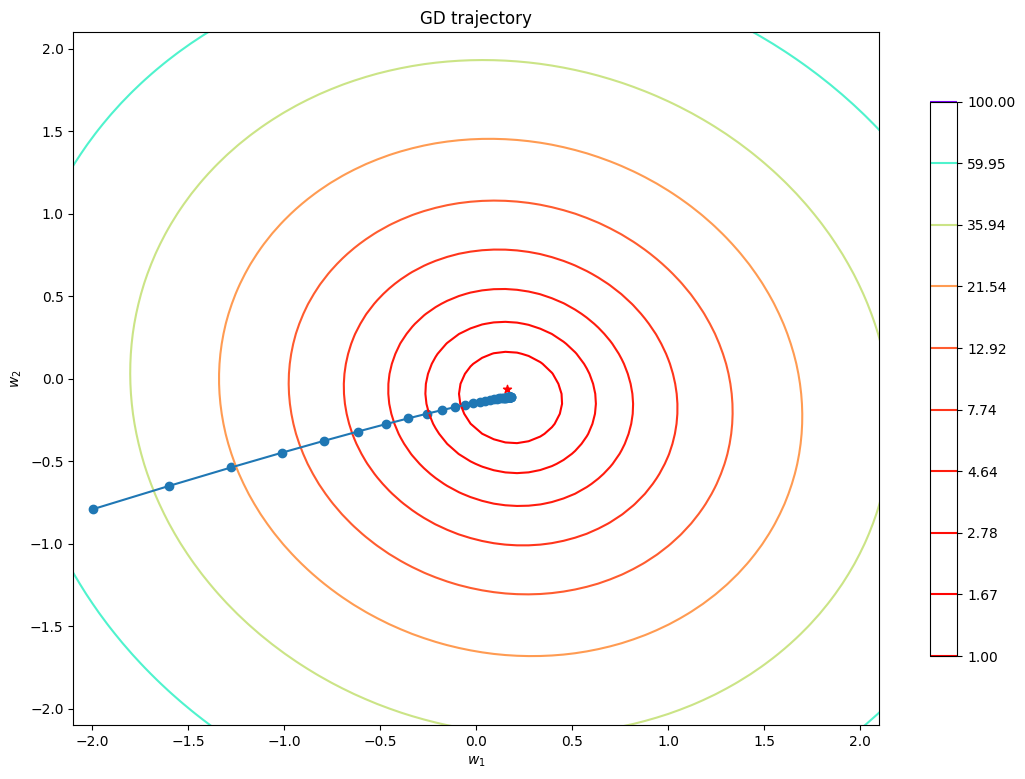

In [8]:
lr = LinearRegression(w0=w_0)
lr.fit(X, y)

plot_gd(X, y, lr.w_history)

### Влияние размера шага на сходимость

Давайте сравним, как изменится поведение полного градиентного спуска в зависимости от размера шага.

$\alpha = 0.0001$

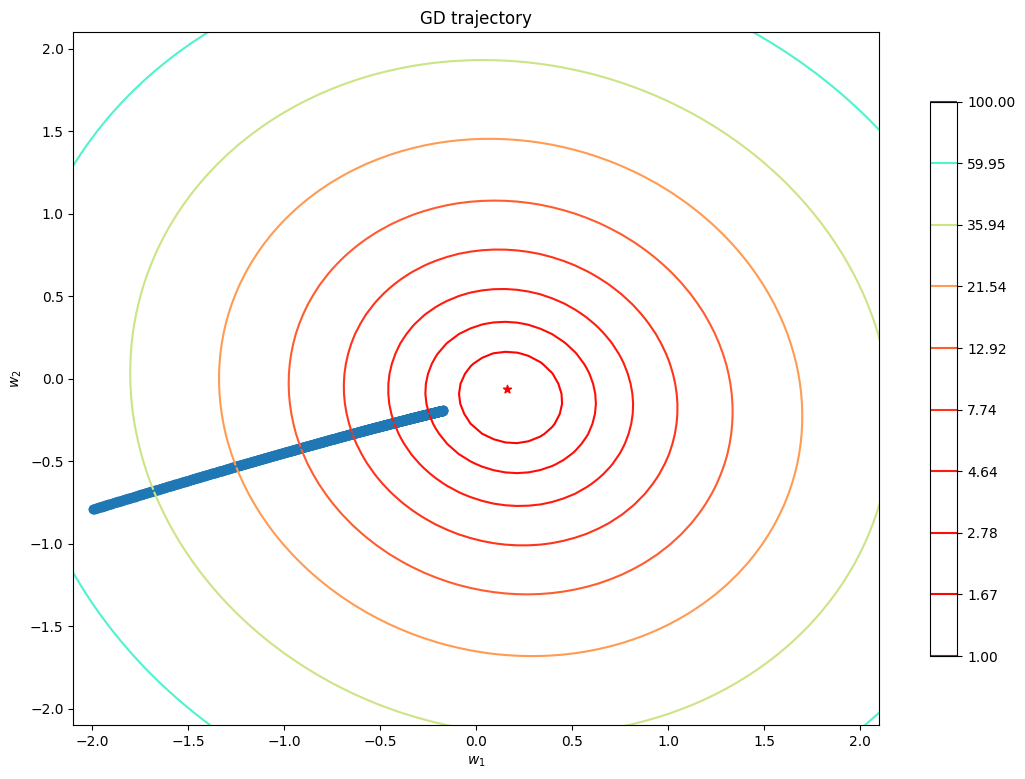

In [10]:
lr = LinearRegression(w0=w_0, alpha=0.0001)
lr.fit(X, y)
plot_gd(X, y, lr.w_history)

$\alpha = 0.01$

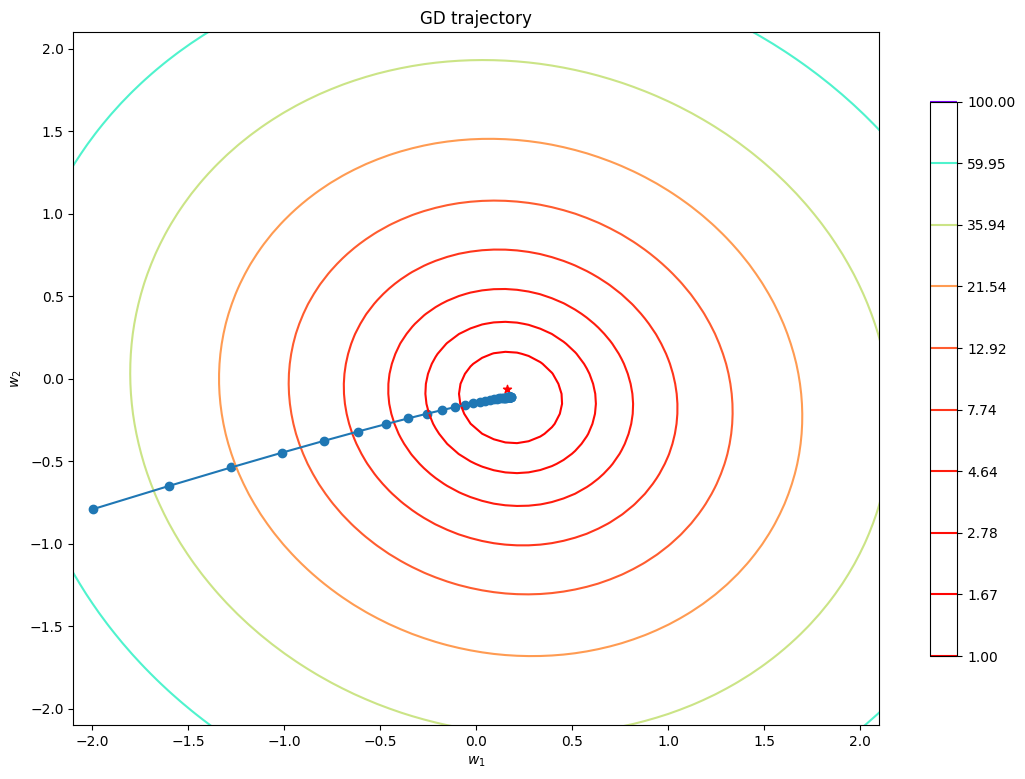

In [11]:
lr = LinearRegression(w0=w_0, alpha=0.01)
lr.fit(X, y)
plot_gd(X, y, lr.w_history)

$\alpha = 0.1$

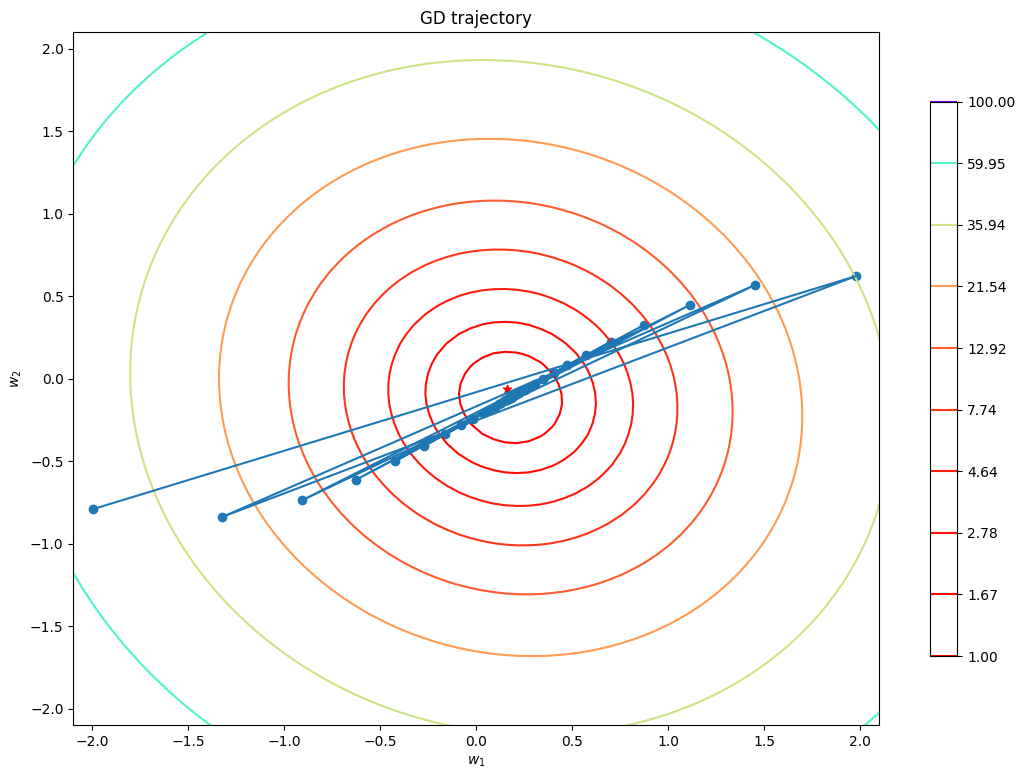

In [12]:
lr = LinearRegression(w0=w_0, alpha=0.1)
lr.fit(X, y)
plot_gd(X, y, lr.w_history)

### Масштабирование функции

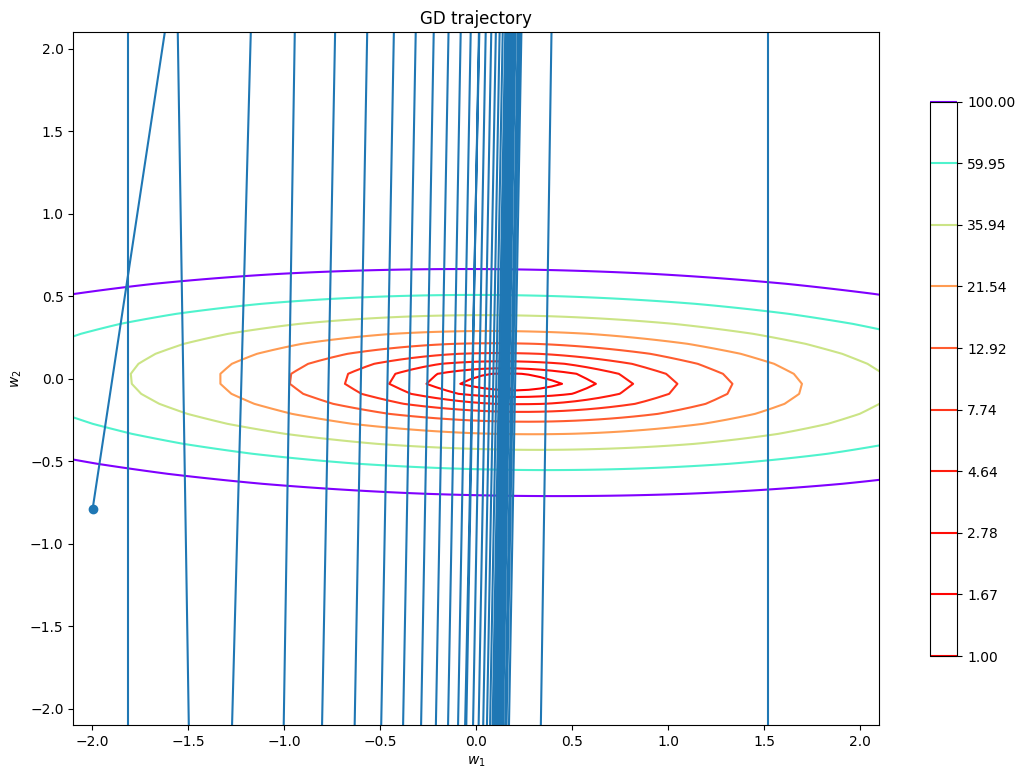

In [13]:
X_new = X.copy()
X_new[:,1] = X_new[:,1] * 5

lr = LinearRegression(w0=w_0, alpha=0.01)
lr.fit(X_new, y)
plot_gd(X_new, y, lr.w_history)

## Бонус

### Реализация полного градиентного спуска с матричными операциями

Градиент в матричной форме $$\nabla Q(w) = -2X^Ty + 2X^TXw = 2X^T(Xw - y).$$

In [14]:
class LinearRegressionVectorized(BaseEstimator):
    def __init__(self, epsilon=1e-4, max_steps=1000, w0=None, alpha=1e-2):
        """
        epsilon: разница для нормы изменения весов
        max_steps: максимальное количество шагов в градиентном спуске
        w0: np.array (d,) - начальные веса
        alpha: шаг обучения
        """
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.w_history = []

    def fit(self, X, y):
        """
        X: np.array (l, d)
        y: np.array (l)
        ---
        output: self
        """
        l, d = X.shape

        if self.w0 is None:
          self.w0 = np.zeros(d)

        self.w = self.w0

        for step in range(self.max_steps):
          self.w_history.append(self.w)

          w_new = self.w - self.alpha * self.calc_gradient(X, y)

          if (np.linalg.norm(w_new - self.w) < self.epsilon):
            break

          self.w = w_new

        return self

    def predict(self, X):
        """
        X: np.array (l, d)
        ---
        output: np.array (l)
        """

        if self.w is None:
            raise Exception('Not trained yet')

        return np.dot(X, self.w)


    def calc_gradient(self, X, y):
        """
        X: np.array (l, d)
        y: np.array (l)
        ---
        output: np.array (d)
        """
        l, d = X.shape

        return (2/l) * np.dot(X.T,(np.dot(X, self.w) - y))


### Сравнение скорости работы обычной и матричной формы

In [15]:
n_features = 100
n_objects = 10000
num_steps = 2


np.random.seed(1)
w_true = np.random.normal(0, 0.1, size=(n_features, ))
w_0 = np.random.uniform(-2, 2, (n_features))

X = np.random.uniform(-5, 5, (n_objects, n_features))
y = np.dot(X, w_true) + np.random.normal(0, 1, (n_objects))

In [16]:
lr = LinearRegression(w0=w_0, alpha=0.01)
%time lr.fit(X, y)

CPU times: total: 1min 1s
Wall time: 1min 9s


LinearRegression(w0=array([ 1.22842078, -0.44855742,  1.45416742,  0.98848657,  0.22496094,
       -1.4541791 , -1.76032924, -1.51462618, -1.82179249, -1.57002348,
       -1.09716265,  0.85195592,  0.23886793, -1.94977608, -1.71210288,
        1.86910532,  0.27240185, -1.18682706, -0.99069702,  0.97530342,
       -1.21828208,  0.32543571,  1.88007996,  1.38731521, -1.04060896,
       -0.02492114,  0.47982287,  1.3159236 , -1....
        0.22661275,  1.6624254 ,  0.56626484, -0.43996914, -0.05603733,
        0.41724193,  0.19819169,  1.70472571,  1.67493374, -0.42049755,
        1.85305011, -1.30417733, -1.49468192, -1.45968337,  0.02264866,
       -1.91390078,  1.79188084,  1.30846188, -1.93992408, -1.29521498,
       -0.6717457 , -1.47601262,  1.23796277, -0.62105339,  1.76042993,
        0.32805672,  1.51532794,  1.37893778,  1.62156927, -0.16047894,
        0.18538726,  1.19441436, -0.85712459, -0.03898591,  0.39644123]))

In [17]:
lr_vectorized = LinearRegressionVectorized(w0=w_0, alpha=0.01)
%time lr_vectorized.fit(X, y)

CPU times: total: 0 ns
Wall time: 31.2 ms


LinearRegressionVectorized(w0=array([ 1.22842078, -0.44855742,  1.45416742,  0.98848657,  0.22496094,
       -1.4541791 , -1.76032924, -1.51462618, -1.82179249, -1.57002348,
       -1.09716265,  0.85195592,  0.23886793, -1.94977608, -1.71210288,
        1.86910532,  0.27240185, -1.18682706, -0.99069702,  0.97530342,
       -1.21828208,  0.32543571,  1.88007996,  1.38731521, -1.04060896,
       -0.02492114,  0.47982287,  1.3...
        0.22661275,  1.6624254 ,  0.56626484, -0.43996914, -0.05603733,
        0.41724193,  0.19819169,  1.70472571,  1.67493374, -0.42049755,
        1.85305011, -1.30417733, -1.49468192, -1.45968337,  0.02264866,
       -1.91390078,  1.79188084,  1.30846188, -1.93992408, -1.29521498,
       -0.6717457 , -1.47601262,  1.23796277, -0.62105339,  1.76042993,
        0.32805672,  1.51532794,  1.37893778,  1.62156927, -0.16047894,
        0.18538726,  1.19441436, -0.85712459, -0.03898591,  0.39644123]))